In [1]:

import torch # long
import os
import numpy as np
import lightning as L
from torch.utils.data import DataLoader, TensorDataset, random_split
import xarray as xr
from models.model import Wang2024
from lightning.pytorch.loggers import WandbLogger
import wandb
from models.lightning import LitCNN
from models.losses import DistribLoss, PinballLoss, QuantileLoss
import random
import matplotlib
from models.data import get_input_data_for_attribution
import pandas as pd
from captum.attr import IntegratedGradients, DeepLiftShap
import matplotlib.pyplot as plt

In [10]:
input_variable = ['u850','v850']

ds_in = xr.open_dataset('/Data/gfi/users/rogui7909/data/ERA5/dl_inputs_32x32.nc').data_normed
data_in = ds_in.sel(var_name=input_variable).values
tensor_in = torch.Tensor(data_in).type(torch.float32)


In [11]:
tensor_in

tensor([[[[-1.3018e+00, -1.1806e+00, -9.5724e-01,  ...,  1.3966e-01,
            1.4332e-01,  1.0574e-01],
          [-1.2545e+00, -1.2439e+00, -1.0172e+00,  ...,  1.7499e-01,
            1.5381e-01,  1.1009e-01],
          [-1.1721e+00, -1.1717e+00, -1.0671e+00,  ...,  2.0001e-01,
            1.6425e-01,  1.1268e-01],
          ...,
          [-3.5554e-01, -9.3287e-01, -2.4648e-01,  ..., -8.5362e-02,
           -4.1366e-01, -3.8806e-01],
          [-6.2233e-01, -1.0234e+00, -2.7788e-02,  ..., -9.3310e-02,
           -4.0551e-01, -3.9590e-01],
          [-7.8339e-01, -7.6528e-01, -1.8950e-01,  ..., -7.3910e-02,
           -3.9402e-01, -4.0022e-01]],

         [[-1.8761e-01, -2.0218e-01, -2.0810e-01,  ...,  3.3924e-01,
            1.5263e-01, -2.5143e-02],
          [-6.7784e-02, -1.6422e-01, -1.3929e-02,  ...,  4.4040e-01,
            1.2332e-01, -5.5000e-02],
          [ 3.0268e-02, -8.0358e-02,  9.3429e-02,  ...,  3.6451e-01,
            9.0924e-02, -8.5497e-02],
          ...,
     

In [9]:
data.shape

(23011, 2, 32, 32)

In [3]:
%matplotlib inline

In [ ]:



def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

learning_rate = 0.001
batch_size = 128
num_epochs = 20
device = 'cuda:1'
input_variable = ['u850']
groups = 1
loss_fn = 'pinball90'
region_predicted = 14
type_prediction='regression'


match loss_fn:
    case 'distrib':
        loss = DistribLoss()
    case 'mse':
        loss = torch.nn.MSELoss()
    case 'pinball90':
        loss = PinballLoss(.9)
    case 'quantile90':
        loss = QuantileLoss(90)
    case 'cross_entropy':
        loss = torch.nn.CrossEntropyLoss()
    



if type_prediction == 'quantiles':
    num_classes = 10
elif type_prediction == 'regression':
    num_classes =  1


config = {
    "hidden_layer_sizes": [32, 64],
    "kernel_sizes": [3],
    "activation": "ReLU",
    "pool_sizes": [2],
    "dropout": 0.5,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "num_classes": num_classes,
    "learning_rate":learning_rate,
    "input_variable" :input_variable,
    "groups" : groups,
    "region_predicted":region_predicted,
    "type_prediction":type_prediction,
    "loss_fn":loss_fn,

}

In [115]:

CNN = Wang2024(num_classes=config['num_classes'], num_channels_in=len(config['input_variable']), image_size=100*256, 
               groups=config['groups'])

# .load_from_checkpoint('u850_regression.ckpt')
model = LitCNN.load_from_checkpoint('u850_regression.ckpt', model=CNN)
model.eval()


LitCNN(
  (model): Wang2024(
    (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=76800, out_features=96, bias=True)
    (fc2): Linear(in_features=96, out_features=48, bias=True)
    (fc3): Linear(in_features=48, out_features=1, bias=True)
  )
  (loss_fn): DistribLoss()
)

In [6]:
all_data, coords = get_input_data_for_attribution(config['input_variable'], config['region_predicted'], config['type_prediction'], config['batch_size'])


In [49]:
all_data

In [7]:
trainer = L.Trainer()
prediction = trainer.predict(model,all_data)
prediction_array = torch.cat(prediction).numpy().squeeze()
truth_array = all_data.tensors[1].numpy().squeeze()


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/felles_gfi/felles_gfi_users/rogui7909/miniforge3/envs/robin/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_D

Predicting: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [12]:
ds = xr.open_dataset('/Data/gfi/users/rogui7909/data/ERA5/u850.nc')
lon_extent = slice(-90,89.5)
lat_extent = slice(20,90)
data_ = ((ds.u850)/ds[f'std_u850'])
data_ = data_.sel(latitude=lat_extent, longitude=lon_extent)

In [116]:
ig = IntegratedGradients(model.model, multiply_by_inputs=True)
dl = DeepLiftShap(model.model)

In [9]:
baseline = all_data.tensors[0].mean(dim=0)


In [60]:
data_true_extreme_winter_index = np.where((truth_array>=20)&(prediction_array>=20)&(coords['time'].time.dt.season=='DJF').values)
data_true_extreme_winter = all_data.tensors[0][data_true_extreme_winter_index]

data_true_extreme_summer_index = np.where((truth_array>=20)&(prediction_array>=20)&(coords['time'].time.dt.season=='JJA').values)
data_true_extreme_summer = all_data.tensors[0][data_true_extreme_summer_index]

In [168]:
torch.manual_seed(42)
with torch.no_grad():
    attribution, delta = ig.attribute(data_true_extreme_winter[:10], baselines=torch.stack([baseline for k in range(10)]), n_steps=50, return_convergence_delta=True)
    print(model.model(data_true_extreme_winter[:10]).squeeze())
    print(delta)
    print(attribution.sum(axis=[2,3]).squeeze())

tensor([16.9443, 33.7804, 28.1553, 23.0509, 27.7868, 19.5291, 18.4494, 30.8186,
        29.7553, 27.4342])
tensor([-2.9692, -2.6340, -0.2643, -1.7188, -1.0098, -1.6447,  3.8466, -2.1474,
        -0.6127, -3.2582], dtype=torch.float64)
tensor([23.1599, 29.0368, 18.0722, 18.3683, 26.6150, 20.1822, 16.7215, 31.0297,
        23.4431, 24.1056], dtype=torch.float64)


In [161]:
 attribution, delta = ig.attribute(data_true_extreme_winter[:1], baselines=baseline, n_steps=50, return_convergence_delta=True)

In [ ]:
attribution.

tensor([[[[-2.0712e-04,  1.0584e-04, -2.7956e-04,  ..., -2.2805e-03,
           -1.9174e-03, -9.6825e-05],
          [-2.4462e-04, -1.0411e-03, -5.1321e-05,  ..., -1.4308e-03,
           -8.4364e-04,  1.4127e-04],
          [-3.3563e-04, -5.0058e-04, -8.2820e-04,  ..., -5.7836e-03,
           -8.2646e-03, -3.1510e-03],
          ...,
          [ 6.5557e-04, -7.6708e-05,  2.4025e-03,  ..., -1.6664e-03,
           -4.4602e-04, -6.4948e-04],
          [ 8.7424e-04,  2.7364e-03, -4.6588e-04,  ..., -2.6351e-03,
           -1.4593e-03, -1.8854e-03],
          [ 5.1792e-04, -2.9520e-04,  1.3150e-03,  ...,  2.4980e-04,
           -9.4948e-04,  1.3285e-04]]],


        [[[ 5.4819e-06, -1.0832e-04, -2.4037e-05,  ..., -5.3914e-03,
           -2.0578e-03, -2.3968e-04],
          [ 3.5867e-05, -9.5515e-05, -3.2432e-04,  ..., -4.7680e-03,
           -2.2912e-03, -8.4519e-04],
          [-4.4840e-05, -1.8633e-04, -3.2062e-04,  ..., -5.9486e-03,
           -1.5014e-02, -2.0887e-03],
          ...,
   

In [205]:
(attribution_ds_winter.coarsen(longitude=4, latitude=4).sum().T.min('time').hvplot(geo=True, coastline=True, x='longitude', y='latitude', cmap='RdBu_r', clim=(-5,5), projection=ccrs.Orthographic(0, 30), title='Minimum attribution')
+
attribution_ds_winter.coarsen(longitude=4, latitude=4).sum().T.max('time').hvplot(geo=True, coastline=True, x='longitude', y='latitude', cmap='RdBu_r', clim=(-5,5),  projection=ccrs.Orthographic(0, 30), title='Maximum attribution')
+
attribution_ds_winter.coarsen(longitude=4, latitude=4).sum().T.mean('time').hvplot(geo=True, coastline=True, x='longitude', y='latitude', cmap='RdBu_r', clim=(-5,5),  projection=ccrs.Orthographic(0, 30), title='Mean of attribution')
+
attribution_ds_winter.coarsen(longitude=4, latitude=4).sum().T.std('time').hvplot(geo=True, coastline=True, x='longitude', y='latitude', cmap='RdBu_r', clim=(-5,5),  projection=ccrs.Orthographic(0, 30), title='STD of attribution')).cols(2)


:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV  :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]

In [ ]:
attribution = ig.attribute(data_true_extreme_winter, baselines=baseline)
attribution_ds_winter = xr.DataArray(attribution.squeeze(), 
                              dims=['time','latitude','longitude'],
                              coords = dict(time=coords['time'][data_true_extreme_winter_index],
                                            longitude=data_['longitude'],
                                            latitude=data_['latitude'],
                                            )).transpose('time','longitude','latitude')

attribution = ig.attribute(data_true_extreme_summer, baselines=baseline)
attribution_ds_summer = xr.DataArray(attribution.squeeze(), 
                              dims=['time','latitude','longitude'],
                              coords = dict(time=coords['time'][data_true_extreme_summer_index],
                                            longitude=data_['longitude'],
                                            latitude=data_['latitude'],
                                            )).transpose('time','longitude','latitude')

In [88]:
df_winter = pd.DataFrame(dict(truth=truth_array[data_true_extreme_winter_index], 
                              pred=prediction_array[data_true_extreme_winter_index]), 
                              index = coords['time'][data_true_extreme_winter_index])

In [98]:
df_winter.sort_values('truth', ascending=False).index

DatetimeIndex(['1992-01-11', '2017-12-23', '1973-12-10', '1991-12-13',
               '1975-12-21', '1999-02-04', '1975-12-27', '1975-12-30',
               '2006-12-11', '1966-12-18',
               ...
               '1990-01-09', '1987-02-05', '2014-12-19', '1974-02-22',
               '2004-12-23', '2008-01-26', '1990-02-23', '2015-12-23',
               '2017-12-08', '1964-12-08'],
              dtype='datetime64[ns]', length=356, freq=None)

In [64]:
mean_u850_summer = data_.sel(time=attribution_ds_summer.time).mean('time')
mean_u850_winter = data_.sel(time=attribution_ds_winter.time).mean('time')

In [87]:
import hvplot.xarray
import hvplot.pandas
import cartopy.crs as ccrs

In [ ]:
(attribution_ds_winter.mean('time').rolling(longitude=3,latitude=3).mean().hvplot(geo=True, x='longitude',y='latitude', cmap='RdBu_r',
                                   projection=ccrs.Orthographic(0, 30), coastline=True, title='Winter')
*
mean_u850_winter.hvplot.contour(x='longitude', y='latitude',geo=True, levels=10)
+
(attribution_ds_summer.mean('time').rolling(longitude=3,latitude=3).mean().hvplot(geo=True, x='longitude',y='latitude', cmap='RdBu_r',
                                   projection=ccrs.Orthographic(0, 30), coastline=True, title='Summer')
*
mean_u850_summer.hvplot.contour(x='longitude', y='latitude',geo=True, levels=10)
)

)

:Layout
   .Overlay.I  :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Contours.I  :Contours   [longitude,latitude]   (value)
   .Overlay.II :Overlay
      .Image.I     :Image   [longitude,latitude]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Contours.I  :Contours   [longitude,latitude]   (value)

In [101]:
attribution_ds_winter.sel(time=df_winter.sort_values('truth', ascending=False).index).rolling(longitude=3,latitude=3).mean().hvplot(geo=True, x='longitude',y='latitude', cmap='RdBu_r',
                                   projection=ccrs.Orthographic(0, 30), coastline=True, title='Winter', clim=(-.1,.1))


BokehModel(combine_events=True, render_bundle={'docs_json': {'6e7a07cd-d9b5-49ae-819b-6572cfd7d75e': {'version…

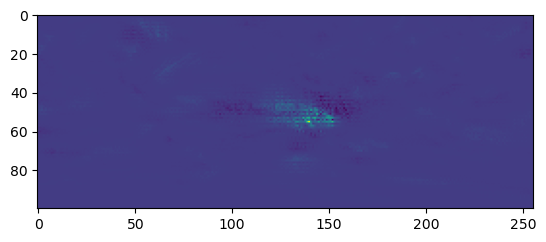

invalid command name "139699014168512process_stream_events"
    while executing
"139699014168512process_stream_events"
    ("after" script)
can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


In [40]:
plt.imshow(ig.attribute(all_data.tensors[0][:1]).squeeze())
plt.show()

tensor([[[ 0.0032, -0.0641, -0.0869,  ...,  0.0580,  0.1026,  0.1496],
         [ 0.0490, -0.0012,  0.0573,  ...,  0.3161,  0.3107,  0.3491],
         [ 0.1593,  0.0652,  0.1420,  ...,  0.6158,  0.5397,  0.5321],
         ...,
         [-0.0685, -0.0659, -0.0632,  ...,  0.1436,  0.1561,  0.1685],
         [ 0.0169,  0.0182,  0.0196,  ..., -0.0777, -0.0712, -0.0649],
         [ 0.0957,  0.0966,  0.0975,  ..., -0.1533, -0.1511, -0.1489]]])